In [466]:
# фиксируем RANDOM_SEED и версию пакетов, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42
!pip freeze > requirements.tx

#импортируем библиотеки
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# прочитаем все данные
df_train = pd.read_csv('data/hotels_train.csv')
df_test = pd.read_csv('data/hotels_test.csv')
sample_submission = pd.read_csv('data/submission.csv')

 # Исследование данных

Будем работать сначала с train датасетом, чтобы не потерять исходное количество строк для сабмишена в тестовом, на случай, если будем что-то удалять. 

In [467]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [468]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


Датасет содержит 18 признаков, из них только 10 числовые. Начнем с исследования числовых, а далее попробуем обработать текстовые и получить понятный для обучения модели формат - числовой, извлекая из них данные через исследование, преобразование, создание новых признаков на базе имеющихся.

# Очистка данных

## Дубли

In [469]:
# Проверим на дубли и избавимся от них, если они есть
all_columns = list(df_train.columns) 
df_duplicates = df_train[df_train.duplicated(subset=all_columns)]
print(f'Number of duplicates: {df_duplicates.shape[0]}')
df_train.drop_duplicates(inplace=True, ignore_index=True) 

Number of duplicates: 307


## Пропуски

In [470]:
# исследуем пропуски
cols_null_percent = df_train.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)
# пропуски есть только в столбцах lat и lng и их там меньше 1%
#заполним строки с пропусками нулями
df_train['lat'] = df_train['lat'].fillna(0)
df_train['lng'] = df_train['lng'].fillna(0)

lat    0.633383
lng    0.633383
dtype: float64

## Выбросы
Исследуем числовые признаки на наличие выбросов и при необходимости преобразуем, для этого посмотрим распределение числовых признаков, посмотрим на их основные статистические характеристики и/или визуализиурем:

In [471]:
# посмотрим на средний балл отеля, рассчитанный на основе последнего комментария за последний год:
df_train['average_score'].describe()

count    386496.000000
mean          8.397421
std           0.547861
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

тут никаих подозрений на выбросы нет, идем дальше

In [472]:
# посмотрим на общее количество слов в отрицательном отзыве
df_train['review_total_negative_word_counts'].describe()

count    386496.000000
mean         18.539400
std          29.703569
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

Максимальный негативный комментарий содержит 408 слов. Это много конечно, вероятно кто-то очень оказался недоволен и был многословен. Так как 50% и 75% квантили гораздо скромнее, а среднее равно 19, то в целом показатели выглядят вполне реальными. Далее:

In [473]:
# посмотрим на общее количество слов в положительном отзыве
df_train['review_total_positive_word_counts'].describe()

count    386496.000000
mean         17.778163
std          21.724766
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: review_total_positive_word_counts, dtype: float64

Картина похожа на предыдущий признак, кто-то был многословен, но, судя по среднему и другим показателям, таких немного, все выглядит нормально. Далее:

In [474]:
# количество отзывов, которые рецензенты дали в прошлом
df_train['total_number_of_reviews_reviewer_has_given'].describe()

count    386496.000000
mean          7.176211
std          11.052453
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

Выглядит крайне подозрительно. Чтобы 1 человек дал 355 отзывов одному отелю просто по доброте душевной, крайне сомнительно. Визуализируем для полноты картины:

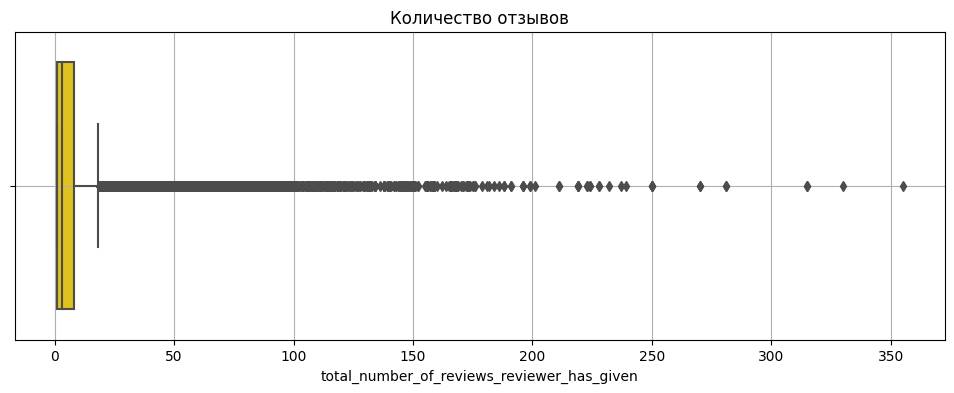

In [475]:
fig, ax = plt.subplots(figsize=(12, 4)) 
# строим boxplot 
sns.boxplot(data=df_train, x='total_number_of_reviews_reviewer_has_given', palette='prism', ax=ax) 
#задаём названия графикам
ax.set_title('Количество отзывов')
plt.grid()


Похоже на накрутки, пусть до 150 отзывов от одного человека будет пределом реальности, посмотрим сколько их подозрительных:

In [476]:
df_train[df_train['total_number_of_reviews_reviewer_has_given'] >= 150]. shape[0]

135

In [477]:
# удалим их и двигаемся далее
df_train = df_train[df_train['total_number_of_reviews_reviewer_has_given'] < 150]

In [478]:
# посмотрим на общее количество действительных отзывов об отеле
df_train['total_number_of_reviews'].describe()

count    386361.000000
mean       2744.838982
std        2316.896827
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3633.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

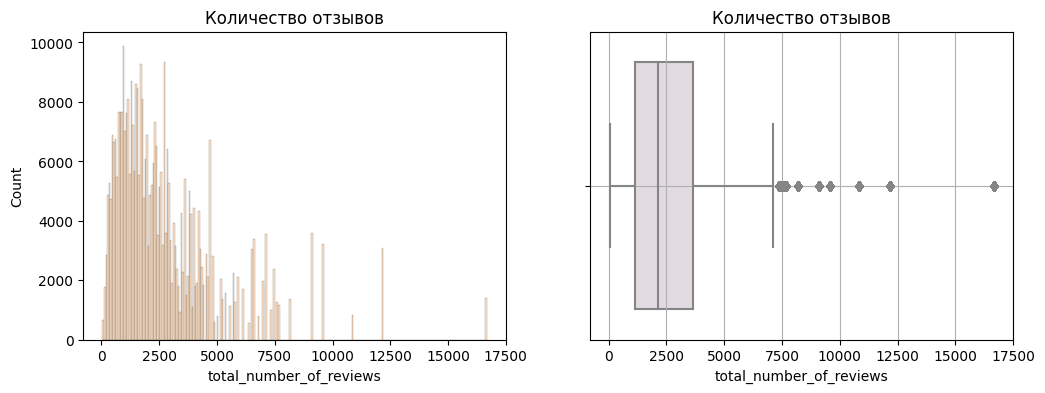

In [479]:
# для полноты картины визуализируем признак:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
#строим гистограмму
sns.histplot(data=df_train, x='total_number_of_reviews',color='peachpuff', ax=axes[0])
# строим boxplot 
sns.boxplot(data=df_train, x='total_number_of_reviews', palette='twilight_shifted', ax=axes[1]) 
#задаём названия графикам
axes[0].set_title('Количество отзывов')
axes[1].set_title('Количество отзывов')
plt.grid()

Видим, что у некоторых отелей зашкаливающе много отзывов, больше 7500!
Проверим, сколько их:

In [480]:
df_train[df_train['total_number_of_reviews']>=7500].shape[0]

15915

In [481]:
# лично я им не верю, хочется удалить их, удаляю
df_train = df_train[df_train['total_number_of_reviews']<7500]

Далее, число оценок без отзывов и без проверки

In [482]:
# для числа оценок без проверки:
df_train['additional_number_of_scoring'].describe()

count    370446.000000
mean        437.951342
std         378.480458
min           1.000000
25%         163.000000
50%         326.000000
75%         597.000000
max        1936.000000
Name: additional_number_of_scoring, dtype: float64

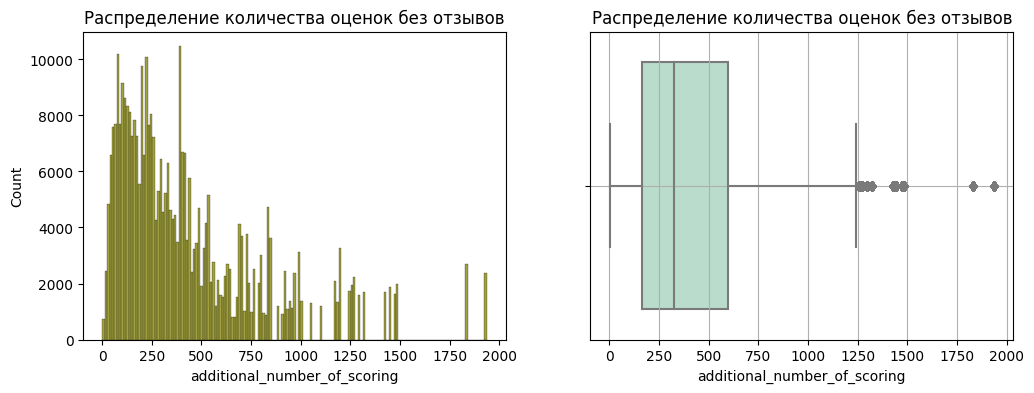

In [483]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
#строим гистограмму
sns.histplot(data=df_train, x='additional_number_of_scoring',color='olive', ax=axes[0])
# строим boxplot 
sns.boxplot(data=df_train, x='additional_number_of_scoring', palette='Pastel2', ax=axes[1]) 
#задаём названия графикам
axes[0].set_title('Распределение количества оценок без отзывов')
axes[1].set_title('Распределение количества оценок без отзывов')
plt.grid()

In [484]:
# количество, превышающее 1500 (справа), выглядит подозрительным. 
# посмотрим, сколько таких строк:
display(df_train[df_train['additional_number_of_scoring']>=1500].shape[0])

5067

In [485]:
# Удалим эти строки:
df_train = df_train[df_train['additional_number_of_scoring'] < 1500]

In [486]:
# Для дальнейшей работы объединим трейн и тест датасеты
# в тесте у нас нет значения reviewer_score, мы его должны предсказать, заполняем нулями
df_test['reviewer_score'] = 0 
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
# обьединяем
df = pd.concat([df_train, df_test], ignore_index = True)
df.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


# Создание и преобразование признаков
### Начнем с даты и времени.

У нас есть столбец с датой отзыва. Переведем его в формат дат, а потом выделим месяц и год отзыва, а также день недели. И, так как возможна сезонность, создадим еще признак времени года. Для создания признака по времени года так же выделим показатель порядкового дня года и закодируем его.  

In [487]:
df['review_date'] = pd.to_datetime(df['review_date'])
# создадим столбец с годом:
df['month'] = df['review_date'].dt.year
# создадим столбец с месяцем отзыва:
df['year'] = df['review_date'].dt.month
# создадим столбец с днем недели:
df['day_of_week'] = df['review_date'].dt.dayofweek
# создадим столбец с порядковым днем года:
df['season'] = df['review_date'].dt.dayofyear
# удалим столбец с датой, тк из него извлекли все, что запланировали
df = df.drop('review_date', axis =1)
display(df.head())


,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,reviewer_score,tags,days_since_review,lat,lng,sample,month,year,day_of_week,season
0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1,2016,2,4,50
1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1,2017,1,3,12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,...,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1,2016,10,1,292
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,...,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,1,2015,9,1,265
4,Via Mecenate 121 20138 Milan Italy,105,8.0,Novotel Milano Linate Aeroporto,France,Nothing,2,1607,Very nice hotel Price is excellent when compa...,16,...,10.0,"[' Business trip ', ' Solo traveler ', ' Super...",582 day,45.448188,9.257046,1,2015,12,2,364


In [488]:
# исследуем новый столбец Season:
df['season'].describe()

count    494314.000000
mean        182.267241
std         102.354702
min           1.000000
25%          96.000000
50%         185.000000
75%         268.000000
max         366.000000
Name: season, dtype: float64

Все выглядит предсказуемо. Закодируем его порядковым кодированием через лямбда функцию так:

Зима: дни с 1 по 60 день плюс 335 по 366, будет закодирована как 1

Весна: с 61 по 153, закодируем как 2

Лето: с 154 по 246, закодируем как 3

Осень: с 247 по 334, закодируем как 4.

In [489]:
df['season']= df['season'].apply(lambda x: 1 if (1<=x<61 or 335<=x<=366) \
    else 2 if 61<=x<=153 \
    else 3 if 154<=x<=246 \
    else 4 )
df['season'].value_counts()

3    139107
2    126164
1    115909
4    113134
Name: season, dtype: int64

 Так же у нас есть столбец days_since_review, который тоже относится ко времени. Сделаем его числовым, откинув слово days/day, и закодируем: пусть отзывы старше года примем старыми и равны 0, а младше года 1. Так как за год может многое пройзойти с отелем и, например, некоторые негативные отзывы в прошлом могут быть неактуальны, если отель успел сделать ремонт. И, наоборот, можно придумать ситуацию обратную с позитивными старыми отзывами. Возьмем год. 

Сам столбец days_since_review удалим, тк он для обучения модели никакой пользы не даст с большой вроятностью.

In [490]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
df['if_old_review']= df['days_since_review'].apply(lambda x: 0 if x>366 else 1)
# удалим изначальный столбец
df = df.drop('days_since_review', axis =1)
df.head(3)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,reviewer_score,tags,lat,lng,sample,month,year,day_of_week,season,if_old_review
0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",51.507894,-0.143671,1,2016,2,4,1,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",51.521009,-0.123097,1,2017,1,3,1,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,...,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",48.845377,2.325643,1,2016,10,1,4,1


### Название отеля и его рейтинг

In [491]:

# сгруппируем отели по среднему рейтингу и количеству
hotels_group = df.groupby('hotel_name').agg({'hotel_name':'count', 'reviewer_score':'mean'}
).rename(columns={'hotel_name': 'count'})
hotels_group = hotels_group.reset_index()
hotels_group = hotels_group.sort_values(by = ['count'], ascending=False).head(15)
display(hotels_group)

,hotel_name,count,reviewer_score
369,Grand Royale London Hyde Park,2958,5.696146
531,Holiday Inn London Kensington,2768,5.862572
516,Hilton London Metropole,2627,5.539284
1018,Millennium Gloucester Hotel London,2565,5.632904
836,Intercontinental London The O2,2551,7.183301
1130,Park Grand Paddington Court,2288,6.227010
520,Hilton London Wembley,2226,6.730997
1138,Park Plaza County Hall London,2222,6.398020
175,Blakemore Hyde Park,2178,6.368365
1140,Park Plaza London Riverbank,2167,6.225473


Видим, что 15 самых частовстречающихся отелей имеют не особенно высокие рейтинги, максимальный 7. Наверное, в среднем это нормально. 

Видим так же, что чаще всего встречаются отели из Лондона. Создадим признак is_London, закодируем 0 - не Лондон, 1 - Лондон. Название города не всегда есть в названии отеля, поэтому для лямбда функции возьмем столбец с адресом.  

In [492]:
df['is_London'] = df['hotel_address'].apply(lambda x: 1 if 'London' in x else 0) 
# удалим столбец с названием
df = df.drop('hotel_name', axis = 1)

### Тэги

Столбец с тэгами имеет текстовый формат, где все тэги заключены в квадратные скобки и  просто перечислены через запятую. Создадим общий список всех тэгов и найдем самые популярные. 

In [493]:
# Уберем квадратные скобки, и преобразуем строку в список тэгов
df['tags'] = df['tags'].apply(lambda x: x[1:-1])
df['tags'] = df['tags'].apply(lambda x: x.split(', '))
#создадим общий список всех тэгов
tags_list = []
for i in df['tags']:
    for j in i:
        tags_list.append(j)

# чтобы убрать повторы, создадим множество из списка тэгов 
tags_list_unique = set(tags_list)

# посчитаем, сколько раз встречается каждый тэг
count_tags = {}
for tag in tags_list:
    if tag not in count_tags:
        count_tags[tag] =1
    else:
        count_tags[tag]+=1
        
# чтобы отсортировать по количеству тэгов, создадим из словаря столбцы dataframe с
# построковым расположением значений словаря
df_dict = pd.DataFrame.from_dict(count_tags, orient='index', columns = ['count'])
# отсортируем по убыванию
df_dict = df_dict.sort_values(by = 'count', ascending=False)
df_dict


,count
' Leisure trip ',400341
' Submitted from a mobile device ',294658
' Couple ',241807
' Stayed 1 night ',184306
' Stayed 2 nights ',127996
...,...
' Double or Twin Junior Suite ',1
' Smart Triple Room ',1
' One Bedroom Apsley Suite ',1
' Two Bedroom Suite with Terrace ',1


In [494]:
# оставим 15 самых популярных тэгов и создадим из них список
top_tags = df_dict.nlargest(15, columns = 'count')
top_tags_list = list(top_tags.index)

In [495]:
# создадим 15 новых столбцов с тэгами горячим кодированием: 
for tag in top_tags_list:
    df[tag] = df['tags'].apply(lambda x: 1 if tag in x else 0)
    


### Страна и город
Отделим город и страну из столбца hotel_address

In [496]:
# посмотрим на столбец
df['hotel_address']
# Страна указана последней, попробуем ее достать:
df['country']= df['hotel_address'].apply(lambda x: x.split()[-1])
display(df['country'].value_counts())
# видим, что все в порядке, но у Великобритании два слова, добавим для порядка,
# хотя для дальнейшего кодирования это не имеет значения:
df['country'] = df['country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
df['country'].value_counts()

Kingdom        247292
Spain           60134
France          59608
Netherlands     53424
Austria         38923
Italy           34933
Name: country, dtype: int64

United Kingdom    247292
Spain              60134
France             59608
Netherlands        53424
Austria            38923
Italy              34933
Name: country, dtype: int64

In [497]:
# стран не много, закодируем через one-hot encoding
df = pd.get_dummies(df, columns=['country'])
df.head(2)

,hotel_address,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,' Double Room ',' Standard Double Room ',' Superior Double Room ',' Family with older children ',country_Austria,country_France,country_Italy,country_Netherlands,country_Spain,country_United Kingdom
0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,0,0,0,0,0,0,0,0,0,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,United Kingdom,poor breakfast,3,1361,location,2,14,...,0,1,0,0,0,0,0,0,0,1


In [498]:
# аналогично создадим столбец с городом. 
df['city'] = df['hotel_address'].apply(lambda x: x.split()[-2])
display(df['city'].value_counts())
# Мы знаем, что United это Великобритания Лондон, поправим
df['city'] = df['city'].apply(lambda x: 'London' if x == 'United' else x)
df['city'].value_counts()

United       247292
Barcelona     60134
Paris         59608
Amsterdam     53424
Vienna        38923
Milan         34933
Name: city, dtype: int64

London       247292
Barcelona     60134
Paris         59608
Amsterdam     53424
Vienna        38923
Milan         34933
Name: city, dtype: int64

In [499]:
# так же закодируем горячим кодированием и удалим столбец с адресом
df = pd.get_dummies(df, columns=['city'])
df = df.drop('hotel_address', axis = 1)
df.head(3)

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna
0,581,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,...,0,0,0,1,0,0,1,0,0,0
1,299,8.3,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,...,0,0,0,1,0,0,1,0,0,0
2,32,8.9,China,No kettle in room,6,406,No Positive,0,14,7.5,...,0,0,0,0,0,0,0,0,1,0


# Нормализация и стандартизация

Рассмотрим распределения исходных числовых признаков на графике методом визуализации kdeplot(): 

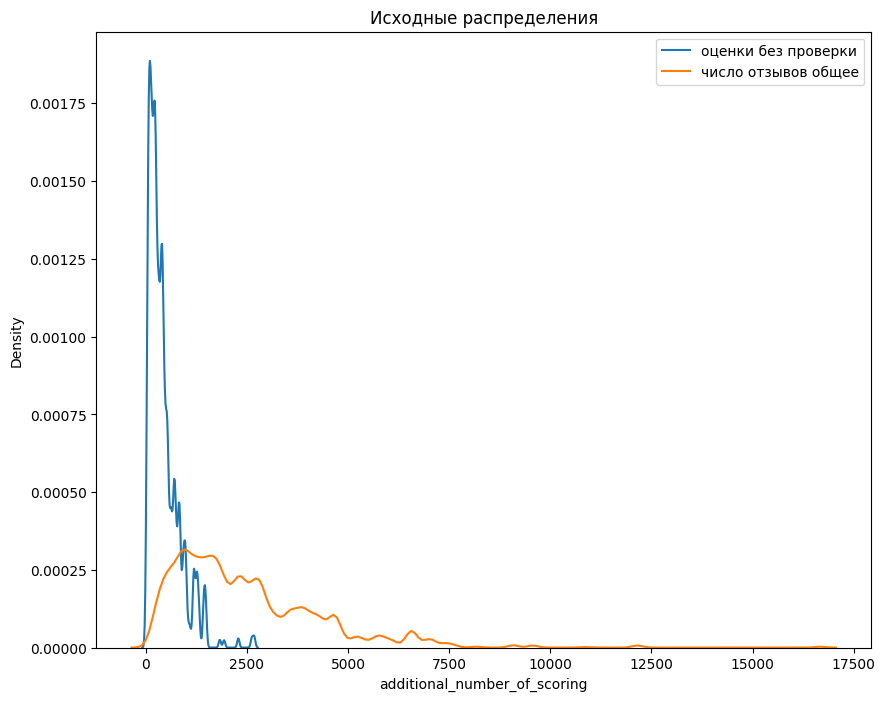

In [500]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['additional_number_of_scoring'], ax=ax1, label ='оценки без проверки')
sns.kdeplot(df['total_number_of_reviews'], ax=ax1, label ='число отзывов общее')
plt.legend()

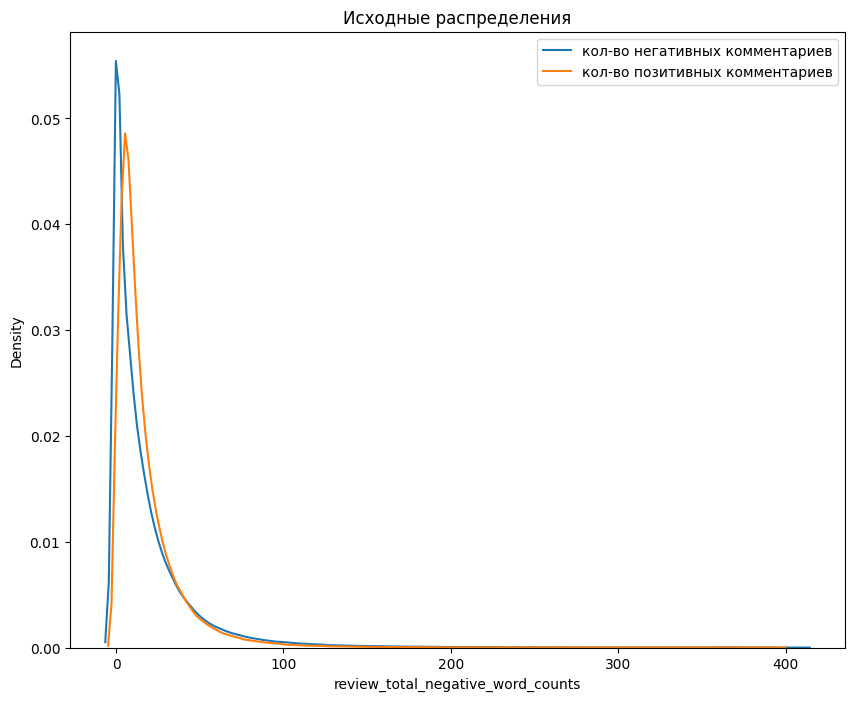

In [501]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['review_total_negative_word_counts'], ax=ax1, label ='кол-во негативных комментариев')
sns.kdeplot(df['review_total_positive_word_counts'], ax=ax1, label ='кол-во позитивных комментариев')
plt.legend()

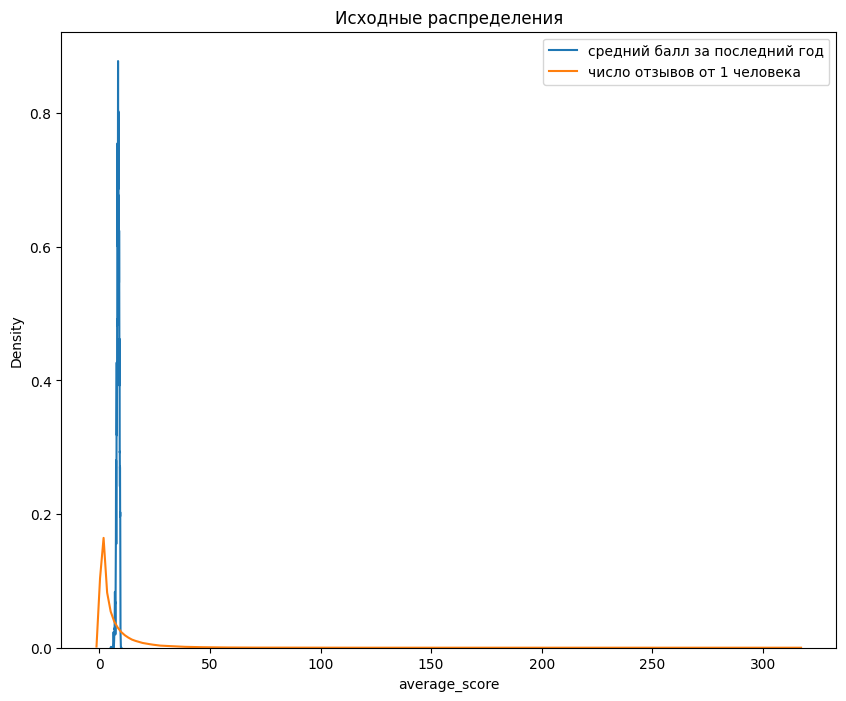

In [502]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['average_score'], ax=ax1, label ='средний балл за последний год')
sns.kdeplot(df['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='число отзывов от 1 человека')
plt.legend()

Соберем эти признаки в один список и нормализуем методом RobustScaler, тк он не учитывает выбросы, которые могут оставаться.

In [503]:
norm_cols = ['additional_number_of_scoring', 'average_score','review_total_negative_word_counts',
'review_total_positive_word_counts','total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given',
]
from sklearn import preprocessing
r_scaler = preprocessing.RobustScaler()
df[norm_cols] = r_scaler.fit_transform(df[norm_cols])
# посмотрим на них
df[norm_cols].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews,total_number_of_reviews_reviewer_has_given
count,494314.000000,494314.000000,494314.000000,494314.000000,494314.000000,494314.000000
mean,0.259728,0.009192,0.450111,0.402675,0.198558,0.594683
std,0.899783,0.779838,1.410894,1.287225,0.802088,1.528671
min,-0.748848,-4.571429,-0.428571,-0.647059,-0.867875,-0.285714
25%,-0.375576,-0.428571,-0.333333,-0.352941,-0.391958,-0.285714
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.624424,0.571429,0.666667,0.647059,0.608042,0.714286
max,5.428571,2.000000,19.000000,22.588235,6.479452,44.571429


# Корреляция

C:\Users\tatye\AppData\Local\Temp\ipykernel_14408\2206628528.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, linewidths=.8, ax=ax, cmap = 'OrRd' )


<AxesSubplot: >

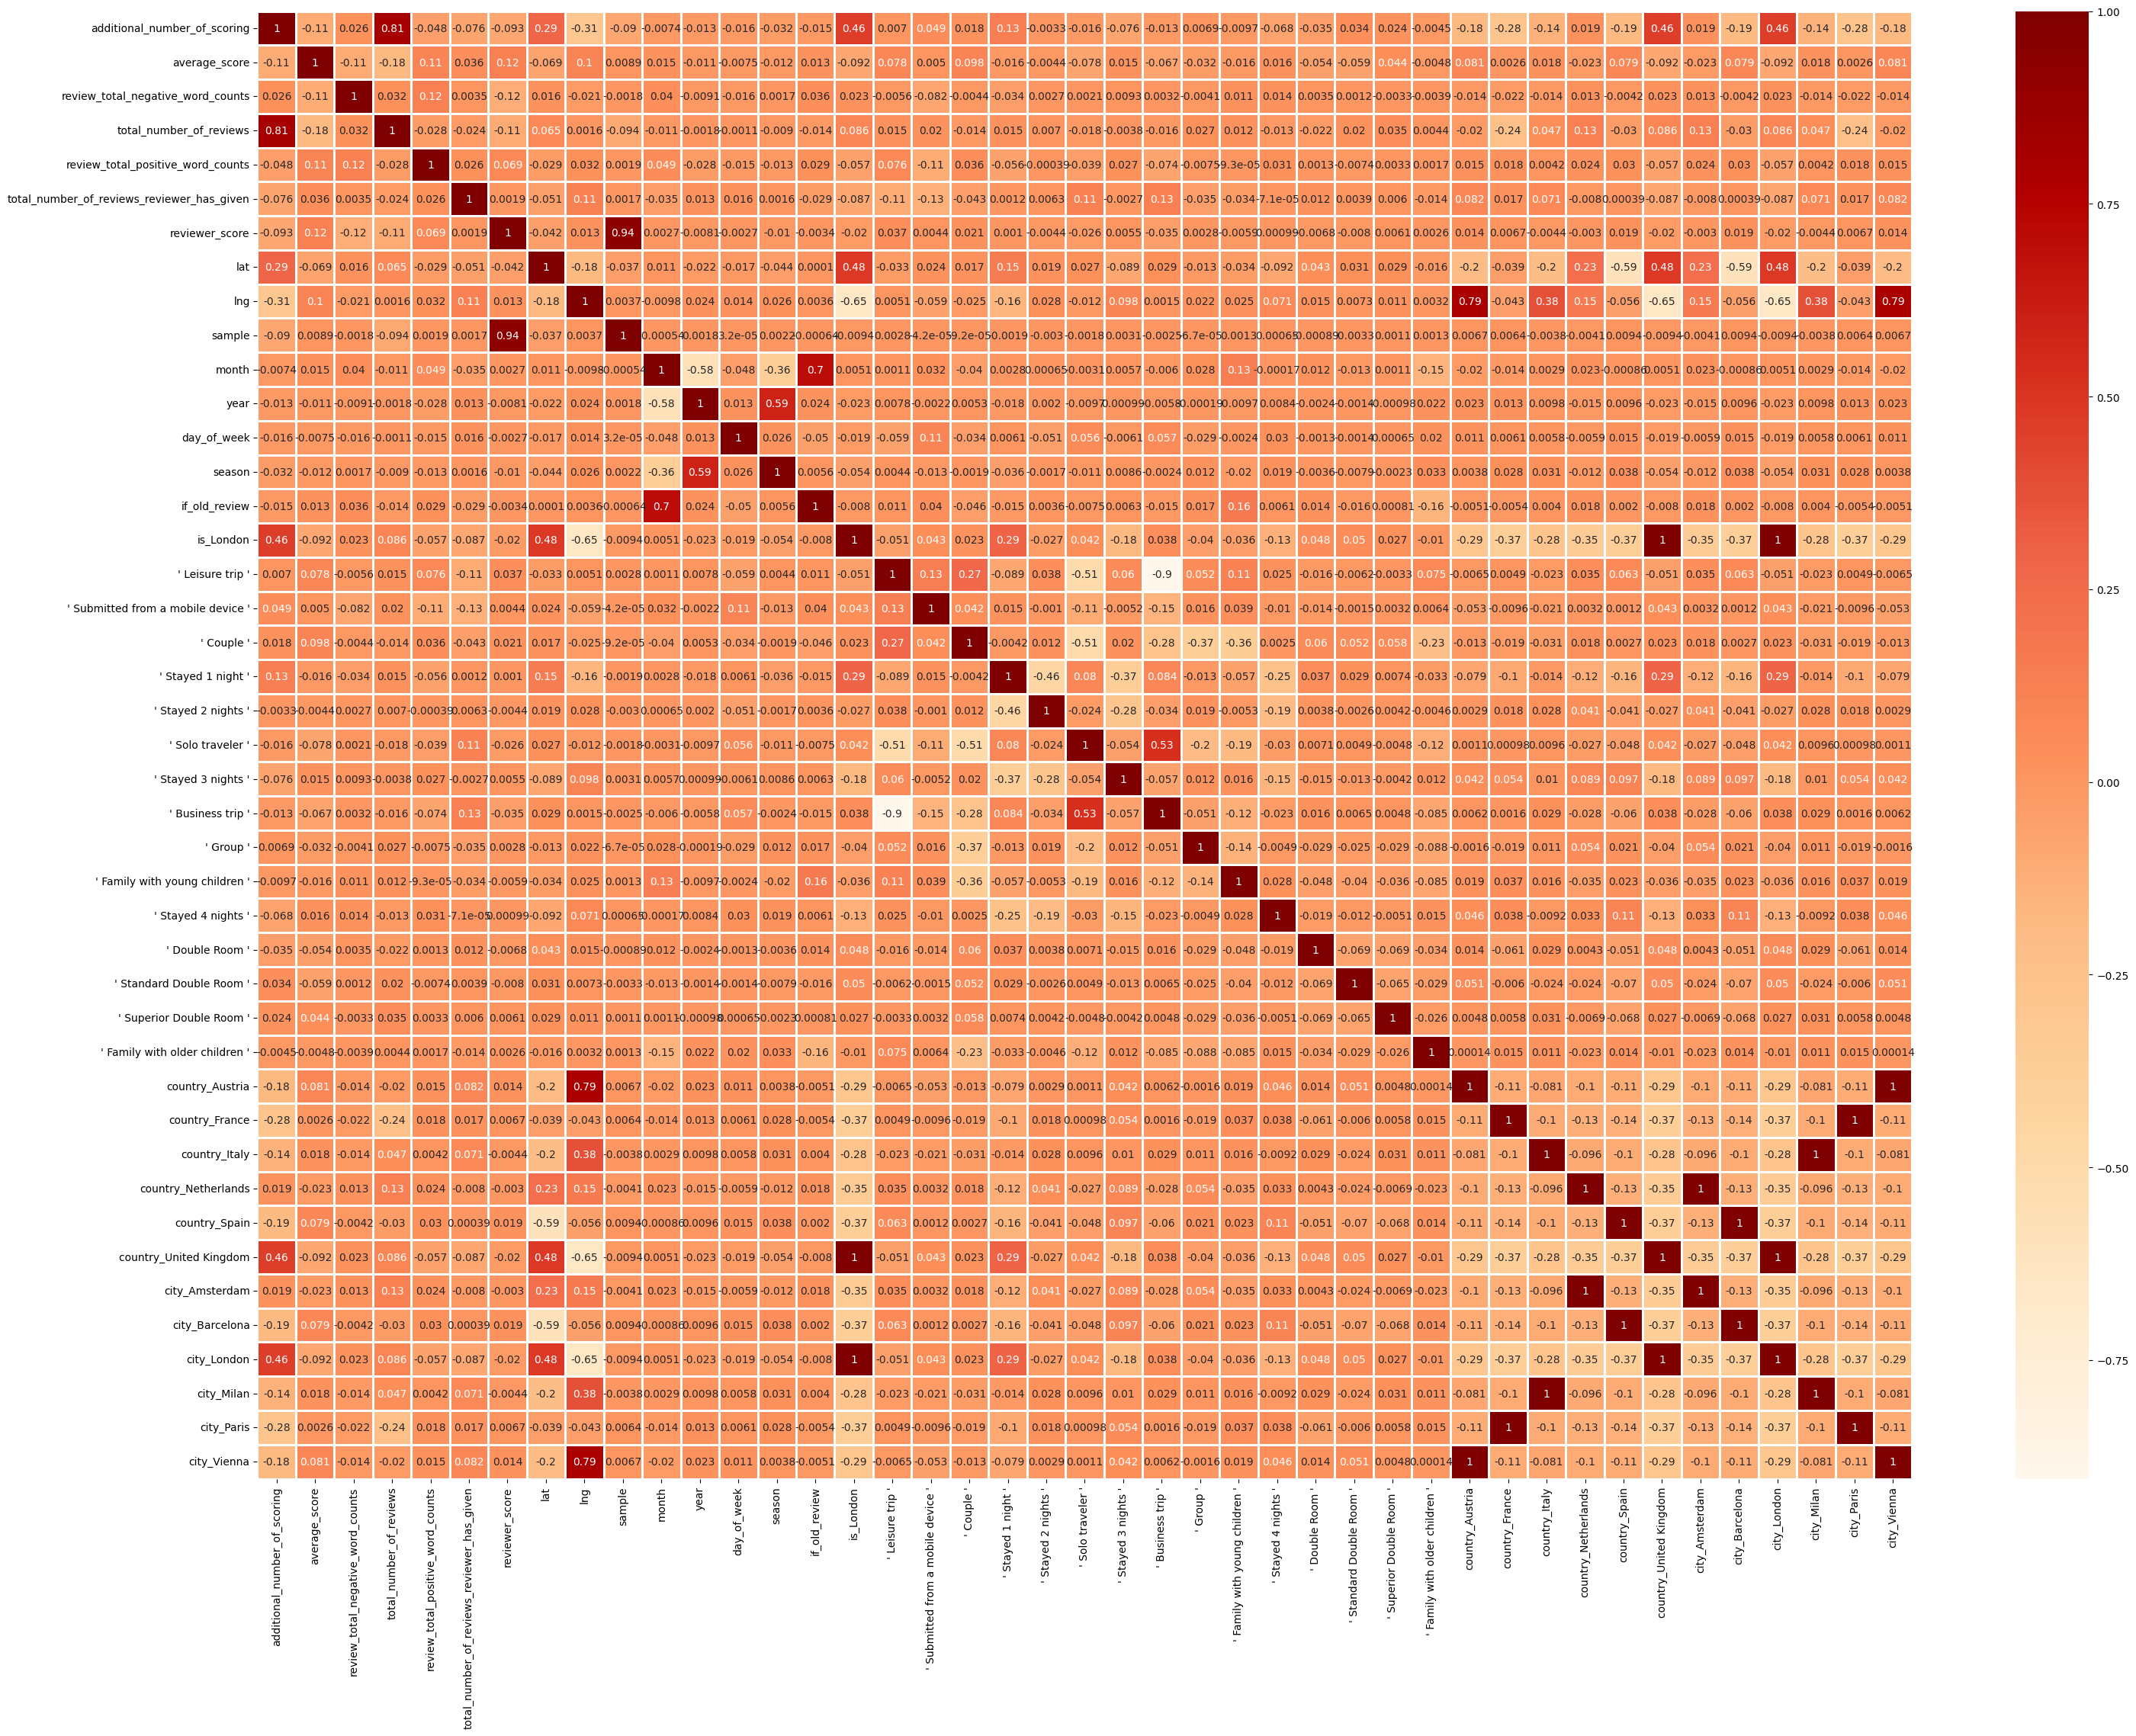

In [504]:
fig, ax = plt.subplots(figsize=(35,25))
sns.heatmap(df.corr(), annot=True, linewidths=.8, ax=ax, cmap = 'OrRd' )

In [505]:
# Видим, что есть некоторое количество признаков, которые обладают сильной прямой или обратной корреляцией.
# Удалим в каждой такой паре по одному:
df = df.drop(columns = ['country_United Kingdom', 'city_London',  'lng','month',
'total_number_of_reviews', 'country_France', 'country_Austria', 'country_Italy',  'country_Spain',
'country_Netherlands', "' Leisure trip '"], axis = 1)

C:\Users\tatye\AppData\Local\Temp\ipykernel_14408\925132067.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method = 'spearman'), annot=True, linewidths=.8, ax=ax, cmap = 'ocean')


<AxesSubplot: >

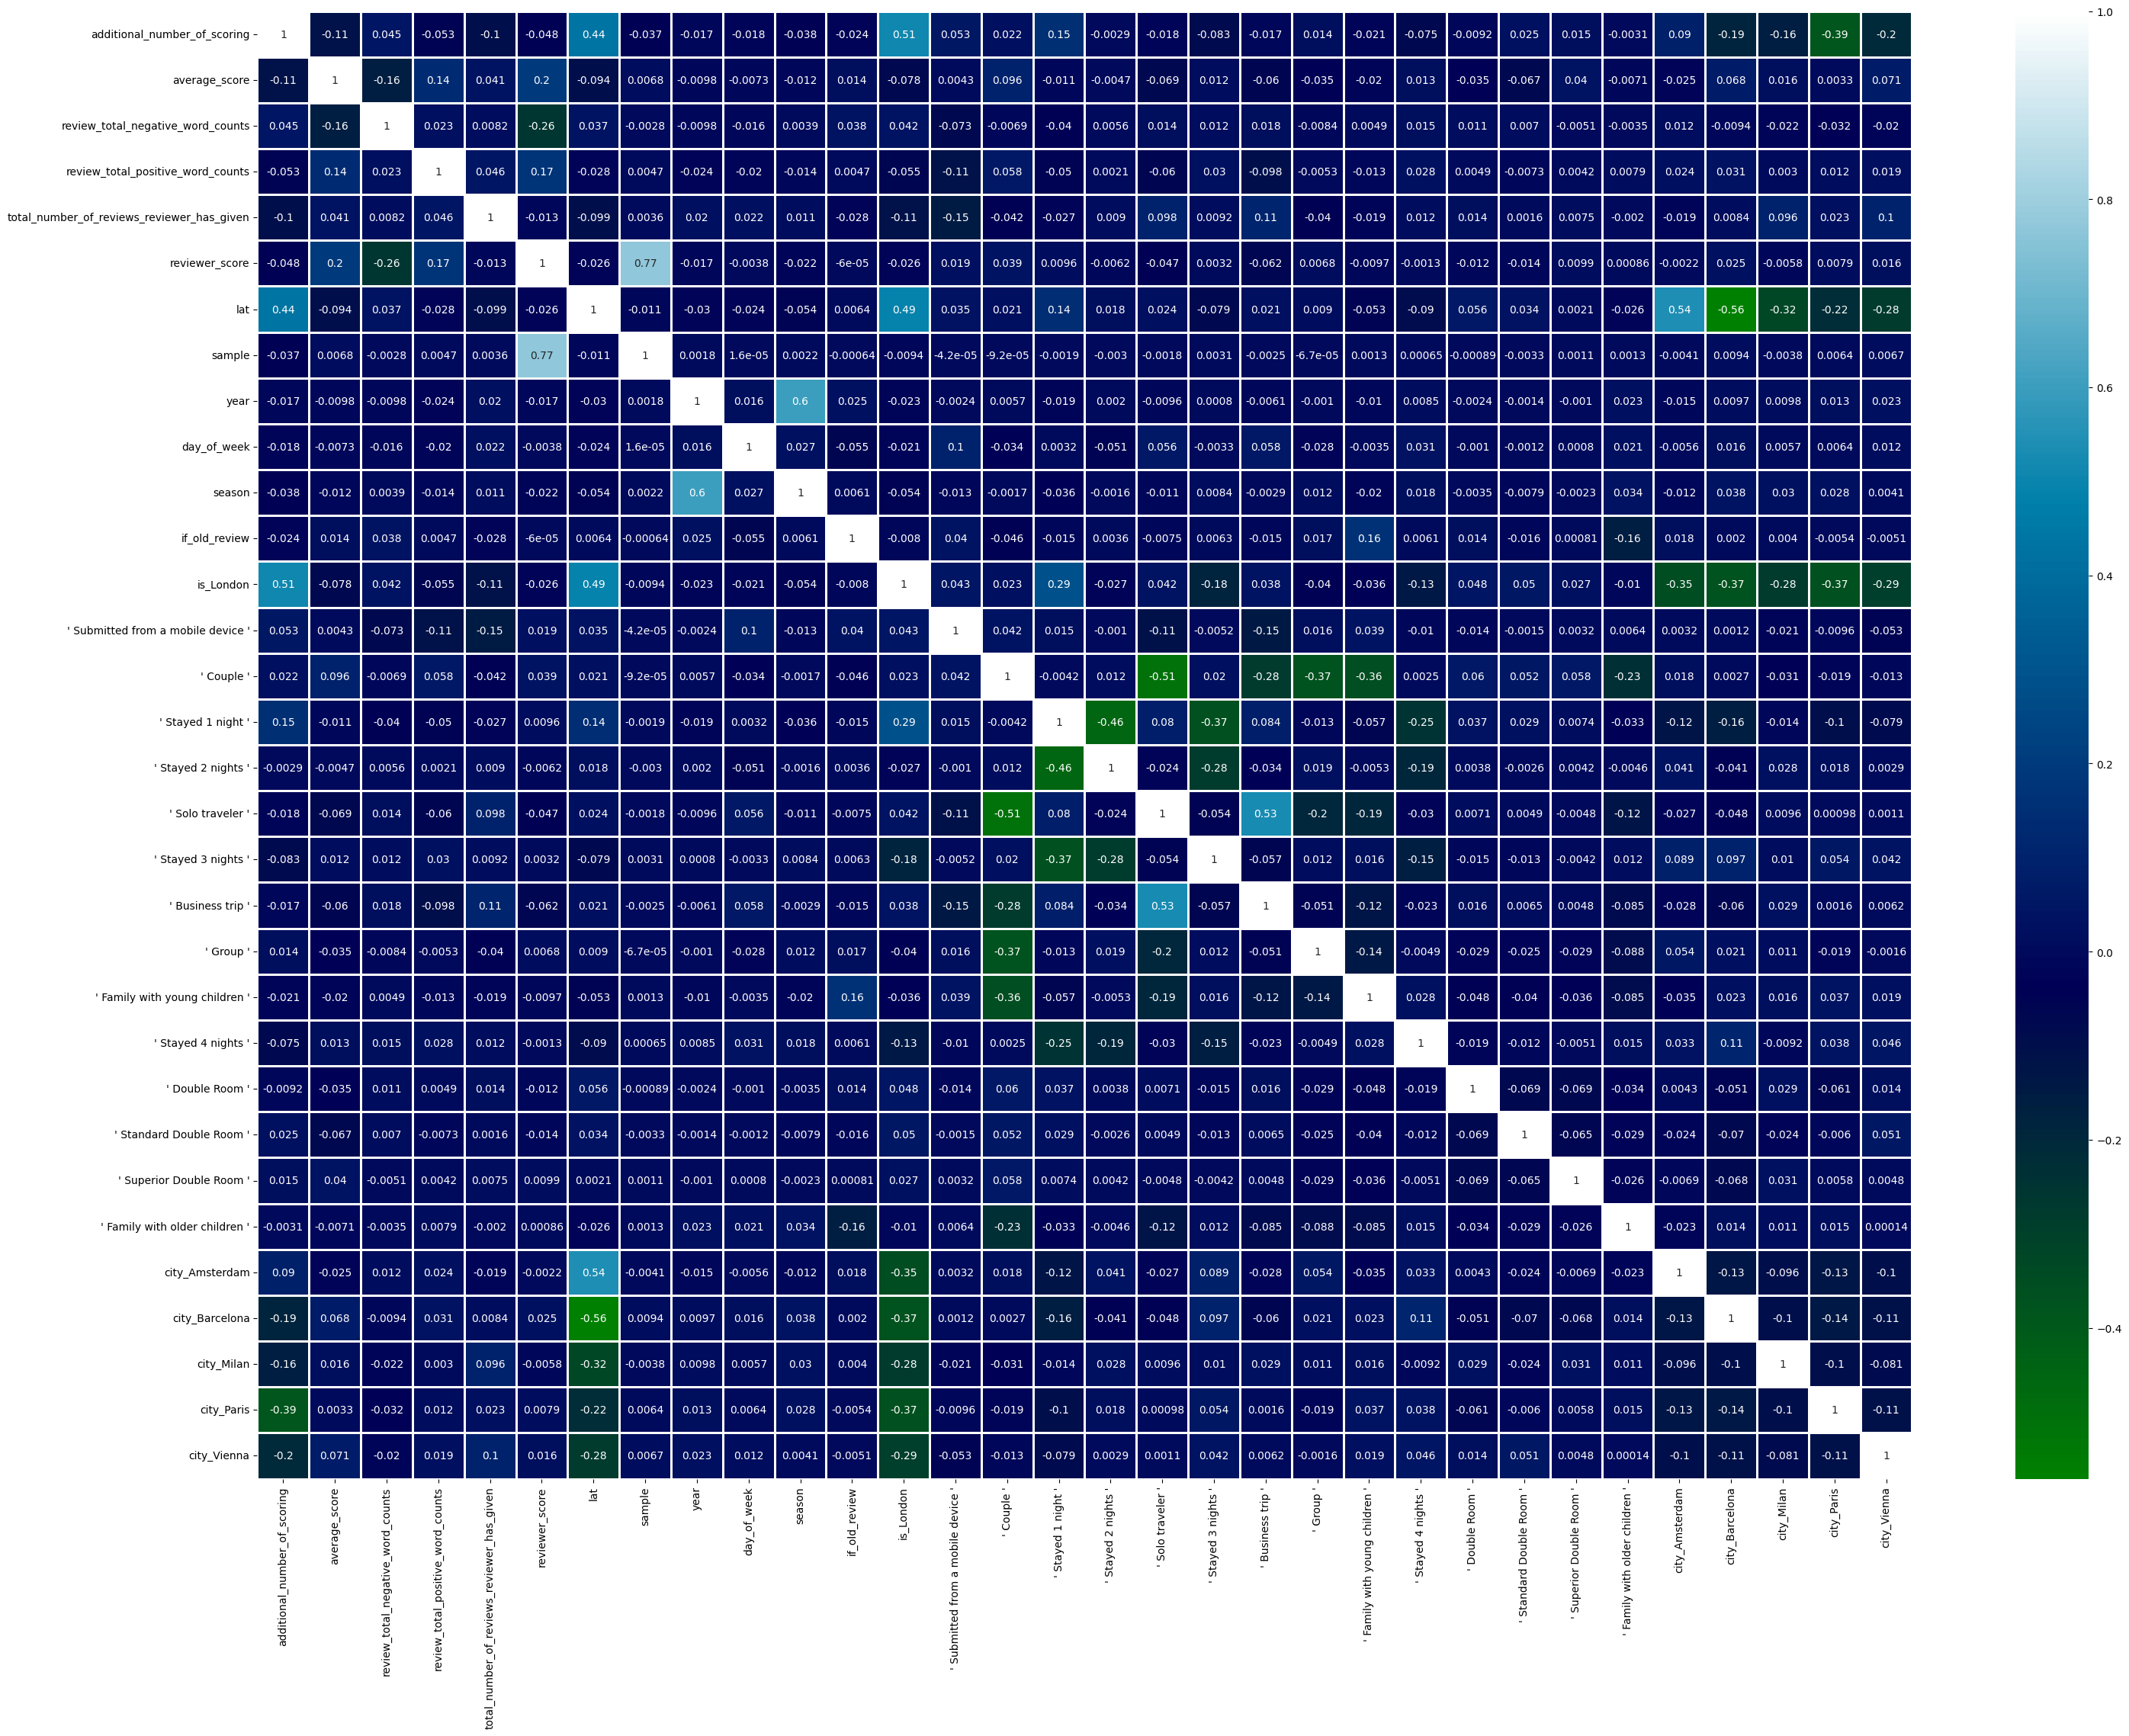

In [506]:
#еще раз глянем на тепловую карту корреляции после очистки, используя метод Спирмена теперь
fig, ax = plt.subplots(figsize=(35,25))
sns.heatmap(df.corr(method = 'spearman'), annot=True, linewidths=.8, ax=ax, cmap = 'ocean')

# Оценка значимости признаков для целевой переменной и обучение модели

In [507]:
# Теперь выделим тестовую часть
train_df = df.query('sample == 1').drop(['sample'], axis=1)
test_df = df.query('sample == 0').drop(['sample'], axis=1)
# таргет
y = train_df.reviewer_score.values          
X = train_df.drop(['reviewer_score'], axis=1)

In [508]:
# непрерывные признаки
num_cols = ['review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'lat', 'average_score']


<AxesSubplot: >

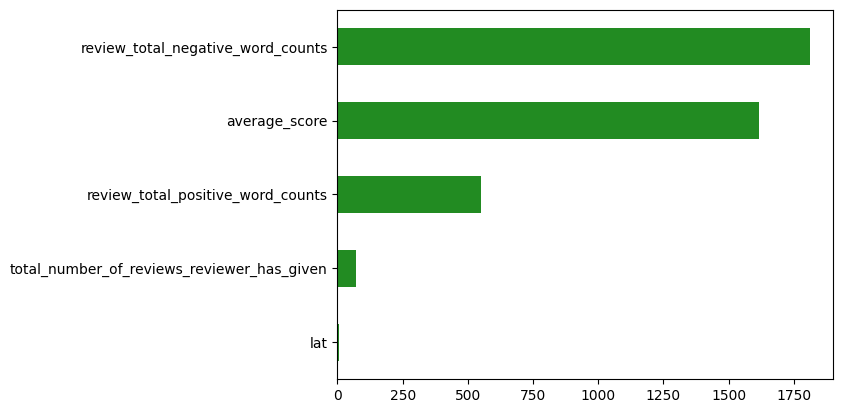

In [509]:
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из
# библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ ANOVA.
from sklearn.feature_selection import f_classif # проведем тест anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color = 'forestgreen')

In [510]:
# удалим малозначимые признаки
df.drop(['lat', 'total_number_of_reviews_reviewer_has_given'], axis=1, inplace=True)

Теперь посмотрим так же на категориальные признаки

<AxesSubplot: >

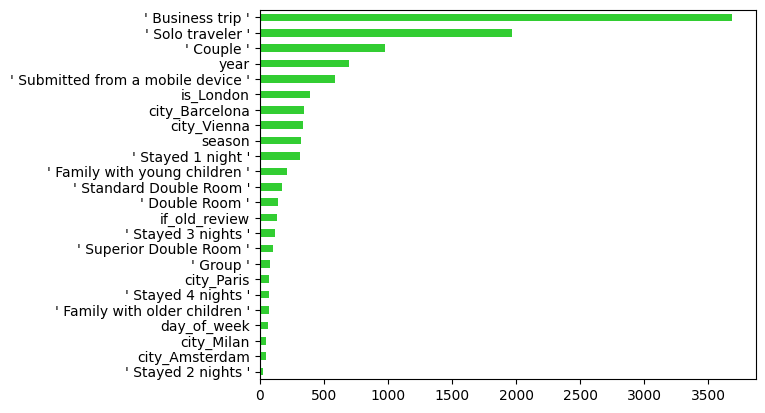

In [511]:
cat_cols = ['year', 'day_of_week', 'season',
       'if_old_review', 'is_London', "' Submitted from a mobile device '", "' Couple '", "' Stayed 1 night '", "' Stayed 2 nights '",
       "' Solo traveler '", "' Stayed 3 nights '", "' Business trip '", "' Group '", "' Family with young children '",
       "' Stayed 4 nights '","' Double Room '", "' Superior Double Room '","' Standard Double Room '",
       "' Family with older children '",'city_Amsterdam', 'city_Barcelona', 'city_Milan', 'city_Paris',
       'city_Vienna']
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color = 'limegreen')

In [512]:
# удалим малозначимые признаки
df.drop(['day_of_week',"' Stayed 2 nights '", "' Stayed 4 nights '","' Family with older children '",
         'city_Paris', "' Group '"], axis=1, inplace=True)


In [513]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)
df.head(3)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,reviewer_score,sample,year,season,if_old_review,is_London,...,' Stayed 3 nights ',' Business trip ',' Family with young children ',' Double Room ',' Standard Double Room ',' Superior Double Room ',city_Amsterdam,city_Barcelona,city_Milan,city_Vienna
0,0.587558,0.000000,-0.285714,-0.411765,10.0,1,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,-0.062212,-0.142857,-0.285714,-0.529412,6.3,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,0
2,-0.677419,0.714286,-0.142857,-0.647059,7.5,1,10,4,1,0,...,1,0,0,0,0,0,0,0,0,0


Разбиваем повторно

In [514]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [515]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split 

In [516]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [517]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 23), (365379, 23), (365379, 22), (292303, 22), (73076, 22))

In [518]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
  
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


In [519]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9443013831278225


In [520]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [521]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


In [522]:
predict_submission

array([8.282, 7.561, 8.066, ..., 8.028, 9.543, 6.969])

In [523]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.282,488440
1,7.561,274649
2,8.066,374688
3,9.527,404352
4,9.620,451596
5,8.786,302161
6,6.786,317079
7,7.810,13963
8,8.519,159785
9,8.038,195089


In [524]:
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.282,488440
1,7.561,274649
2,8.066,374688
3,9.527,404352
4,9.620,451596
5,8.786,302161
6,6.786,317079
7,7.810,13963
8,8.519,159785
9,8.038,195089
